In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import geojson
import os
from text_encoder import get_encode_fn
from pcd_to_geopandas import load_pcd_and_features, convert_to_lat_lon, coord_to_geopandas, aggregate_by_region
import utm

In [21]:
lat_min, lat_max = -34.60311, -34.58030
lon_min, lon_max = -58.38346, -58.35933

In [33]:

# Reading Geographic information and Offers information

geo_data = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson')
years = [2000 + i for i in range(1,21)]
for year in years:
    if not os.path.exists(f"delitos_{year}.csv"):
        url = f"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/terrenos-valor-oferta/Terrenos-en-venta-{year}.zip"
        crimes = pd.read_csv(url)
        crimes.to_csv(f"housing_prices_CABA/offers_{year}.csv", index=False)
    else:
        crimes = pd.read_csv(f"offers_{year}.csv")
        
crime_data = pd.concat([pd.read_csv(f'offers_{year}.csv') for year in years])
crime_data = crime_data.dropna(subset=['longitud', 'latitud'])
crime_data = crime_data[(np.isfinite(crime_data['longitud'])) & (np.isfinite(crime_data['latitud']))]
crime_data = crime_data[(crime_data['latitud'] >= lat_min) & (crime_data['latitud'] <= lat_max) &
                 (crime_data['longitud'] >= lon_min) & (crime_data['longitud'] <= lon_max)]
# crime_data = crime_data[(crime_data["uso_arma"] == "SI")]
latitude = crime_data['latitud'].to_numpy()
longitude = crime_data['longitud'].to_numpy()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [24]:
# caba_rc = gpd.read_file("https://bitsandbricks.github.io/data/CABA_rc.geojson").to_crs(epsg=4326)
# caba_rc['expensiveness_density'] = caba_rc['POBLACION'] / caba_rc['AREA_KM2']
prices_map = gpd.read_file("housing_prices_CABA/Terrenos-en-venta-2019/Terrenos en venta 2019/Terrenos_venta_2019.shp").to_crs(epsg=4326)
prices_map["price_sqm"] = prices_map["PRECIOUSDM"]
prices_map

,OPERACION,TIPO,LATITUD,LONGITUD,M2TOTAL,DIRECCION,CAMBIO,PRECIOUSD,PRECIOARS,PRECIOUSDM,PRECIOARSM,BARRIOS,COMUNA,geometry,price_sqm
0,VTA,TERRENO,-34.6294378,-58.4498948,235.0,Malvinas Argentinas al 400,45.00,1100000.0,49500000,4681.0,210645.0,CABALLITO,6,POINT (-58.44989 -34.62944),4681.0
1,VTA,TERRENO,-34.6289663,-58.4483573,1629.0,Jose Bonifacio 1520,45.00,1400000.0,63000000,859.0,38655.0,CABALLITO,6,POINT (-58.44836 -34.62897),859.0
2,VTA,TERRENO,-34.6265344,-58.4326234,438.0,BONIFACIO JOSE 400,45.00,2380000.0,107100000,1062.0,47790.0,CABALLITO,6,POINT (-58.43262 -34.62653),1062.0
3,VTA,TERRENO,-34.6248406,-58.4317985,272.0,VIEL al 600,45.00,895000.0,40275000,3290.0,148050.0,CABALLITO,6,POINT (-58.43180 -34.62484),3290.0
4,VTA,TERRENO,-34.622629,-58.44079,600.0,Av. Del Barco Centenera 200,45.00,400000.0,18000000,667.0,30015.0,CABALLITO,6,POINT (-58.44079 -34.62263),667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5001,VTA,TERRENO,-34.6184882,-58.46834125,552.0,ARTIGAS al 1000,60.50,850000.0,51425000,1540.0,93170.0,FLORES NORTE,7,POINT (-58.46834 -34.61849),1540.0
5002,VTA,TERRENO,-34.631988,-58.464822,223.0,Alberdi 2600,60.50,580000.0,35090000,2601.0,157361.0,FLORES NORTE,7,POINT (-58.46482 -34.63199),2601.0
5003,VTA,TERRENO,-34.626819,-58.4621,229.0,Caracas 100,60.50,350000.0,21175000,1528.0,92444.0,FLORES NORTE,7,POINT (-58.46210 -34.62682),1528.0
5004,VTA,TERRENO,-34.621818,-58.473141,425.0,Flores Nazca y Paez,60.50,1000000.0,60500000,2353.0,142357.0,FLORES NORTE,7,POINT (-58.47314 -34.62182),2353.0


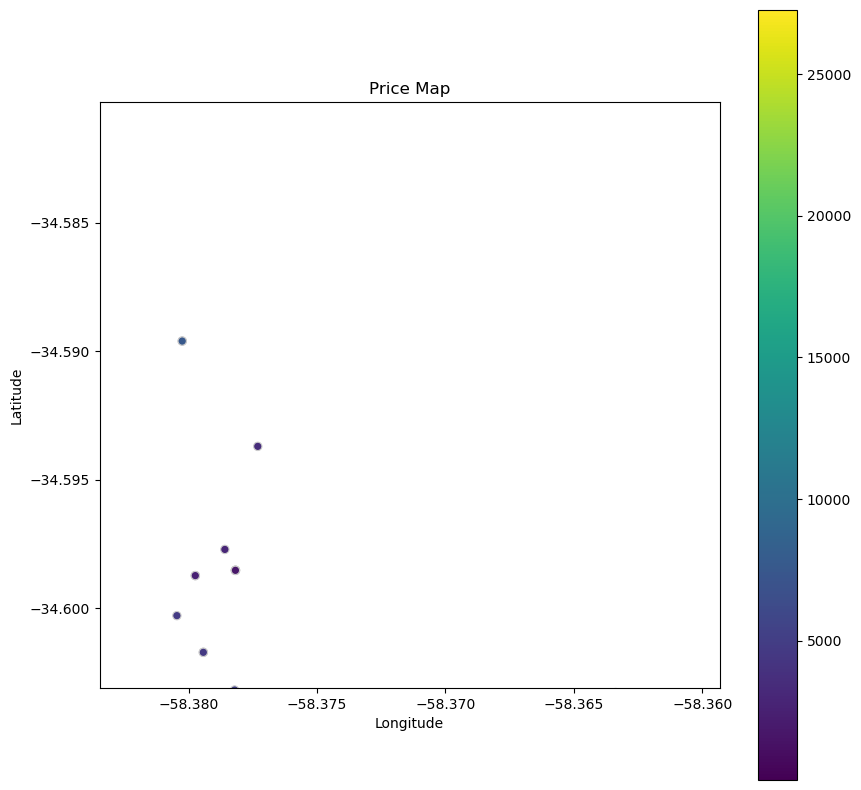

In [31]:
# Heat mapping of population density
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
gt_plot = prices_map.plot(column='price_sqm', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, aspect=1)
plt.title('Price Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [4]:
tag = "buenos-aires-squared"
crop_type = "highlight"
model_type = "siglip"
pcd, features = load_pcd_and_features(tag, crop_type)
model, tokenizer, encode_text = get_encode_fn(model_type=model_type)

(1000000, 1, 1152) (1000000, 3)


c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
queries = ["rich neighborhood", "expensive area", "poor neighborhood",  "cheap area", "nature", "urban area", "unpopulated area"]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)
print(sim.shape)

expensiveness_ratio = sim[:,:2].sum(axis=-1) - sim[:,2] - sim[:,3] + 0.1*sim[:,4]
expensiveness_ratio = np.exp(expensiveness_ratio)
expensiveness_ratio[(features[:,0] == 0).all()] = np.min(expensiveness_ratio[(features[:,0] != 0).any()])

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(1000000, 7)


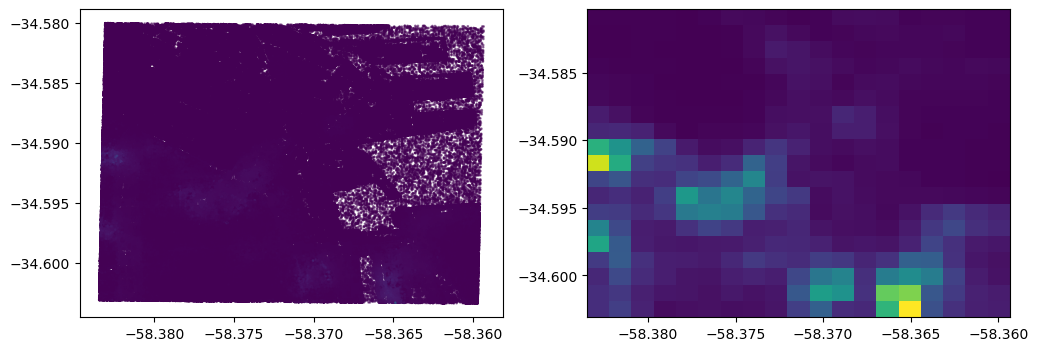

In [6]:
n_bins = 20
xedges = np.linspace(lon_min, lon_max, n_bins)
yedges = np.linspace(lat_min, lat_max, n_bins)

# convert to coordinates by linearly iterpolating between max and min
from scipy.stats import binned_statistic_2d
import numpy as np

pcd_lat_, pcd_lon_ = convert_to_lat_lon(pcd, lat_min, lat_max, lon_min, lon_max)

ret = binned_statistic_2d(pcd_lon_, pcd_lat_, expensiveness_ratio, statistic=np.nanmean, bins=[xedges, yedges])
heatmap_pred = ret.statistic.T

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.scatter(pcd_lon_, pcd_lat_, c=expensiveness_ratio, cmap='viridis', s=1, alpha=0.5)
heatmap_pred_plot = ax1.imshow(heatmap_pred, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')

In [7]:
predicted_expensiveness_density = coord_to_geopandas(pcd_lat_, pcd_lon_, {"expensiveness_ratio":expensiveness_ratio})
caba_rc = aggregate_by_region(caba_rc, predicted_expensiveness_density, prefix="pred_")

c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:32: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  pcd_points_gpd["geometry"] = pcd_points_gpd.apply(lambda row: Point(row['long'], row['lat']), axis=1)
c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Valentin\PycharmProjects\OpenCity\sandbox\pcd_to_geopandas.py:43: FutureWarning: The default value

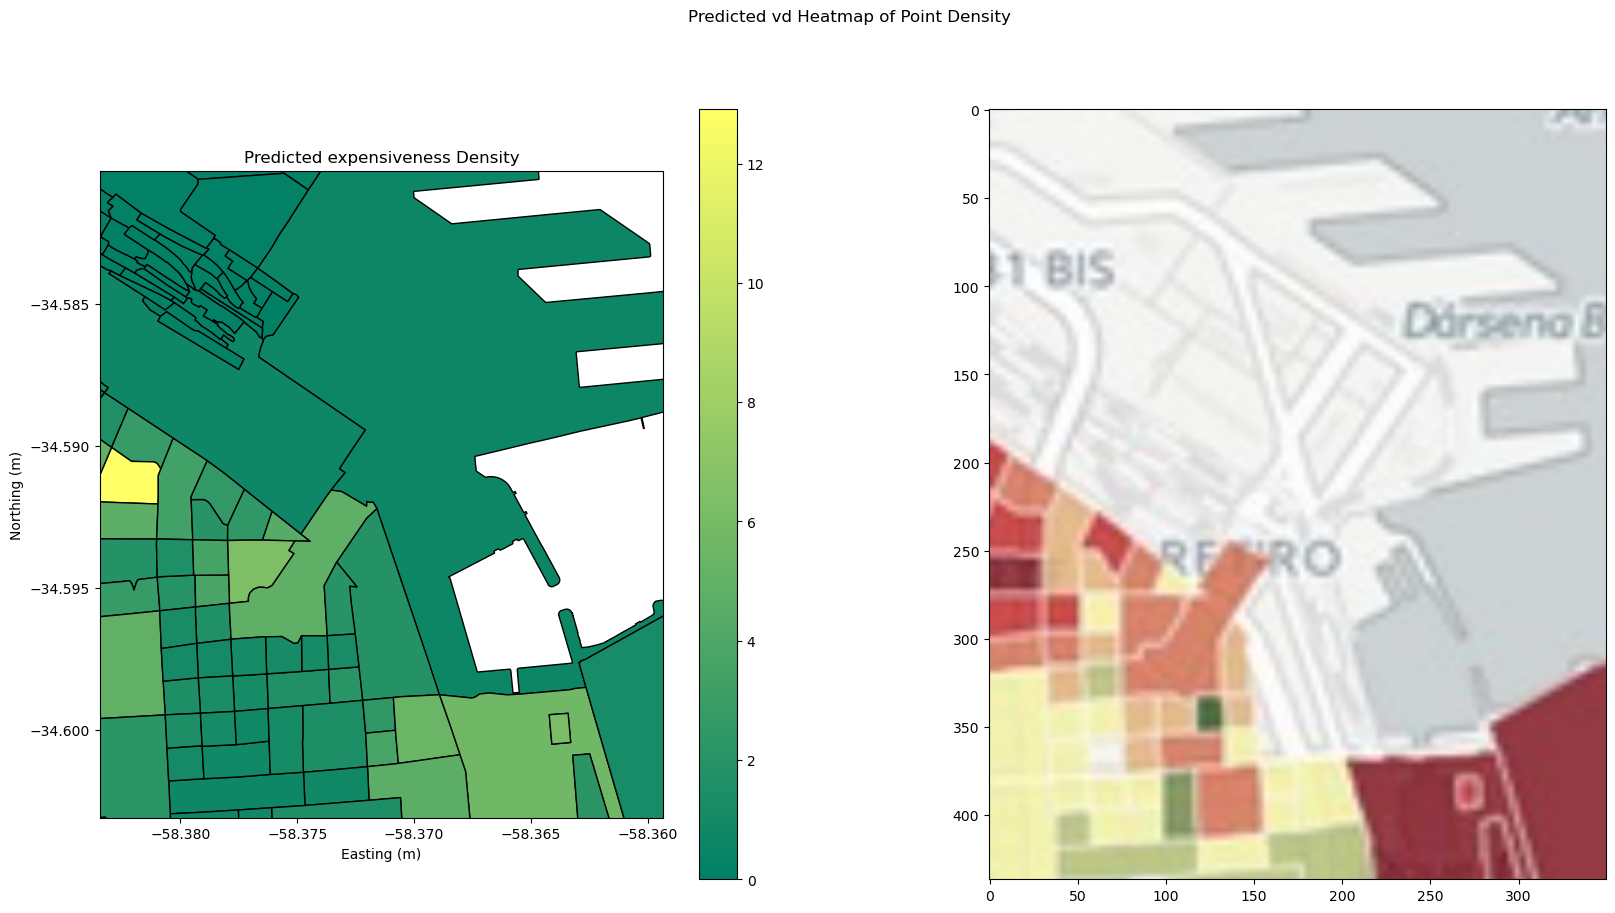

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')

caba_rc.plot(column='pred_avg_expensiveness_ratio', ax=ax[0], legend=True,
             cmap="summer", edgecolor='black')
ax[0].set_xlim([lon_min, lon_max])
ax[0].set_ylim([lat_min, lat_max]) 
ax[0].set_title('Predicted expensiveness Density')
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')

from PIL import Image
ax[1].imshow(Image.open("housing_prices_gt.png"))
plt.suptitle(f'Predicted vd Heatmap of Point Density')
plt.show()